In [1]:
from model import create_model

nn4_small2_pretrained = create_model()

C:\Users\SINDHU\Anaconda3\envs\myenv\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [3]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg' or ext=='.png':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')
print('metadata created')
print(metadata)

metadata created
[images\Ariel_Sharon\Ariel_Sharon_0001.jpg
 images\Ariel_Sharon\Ariel_Sharon_0002.jpg
 images\Ariel_Sharon\Ariel_Sharon_0003.jpg
 images\Ariel_Sharon\Ariel_Sharon_0004.jpg
 images\Ariel_Sharon\Ariel_Sharon_0005.jpg
 images\Ariel_Sharon\Ariel_Sharon_0006.jpg
 images\Ariel_Sharon\Ariel_Sharon_0007.jpg
 images\Ariel_Sharon\Ariel_Sharon_0008.jpg
 images\Ariel_Sharon\Ariel_Sharon_0009.jpg
 images\Ariel_Sharon\Ariel_Sharon_0010.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0001.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0002.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0003.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0004.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0005.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0006.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0007.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0008.jpg
 images\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0009.jpg
 ima

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1) #BGR
    return img[...,::-1] #RGB


alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')

#combined transformation
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [5]:
import pickle
embedded = np.zeros((metadata.shape[0], 128)) 

real_name = {}

embeddings = open('embeddings.pkl','rb')
embedded = pickle.load(embeddings)
embeddings.close()

for i, m in enumerate(metadata):
#     img = load_image(m.image_path())
#     img = align_image(img)
    # scale RGB values to interval [0,1]
#     if img is not None:
#         img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
#         embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    real_name[os.path.dirname(m.image_path()[7:])] = embedded[i]
    print(i)
    print(m.name)
        
# embeddings = open('embeddings.pkl','wb')
# pickle.dump(embedded,embeddings)
# embeddings.close()

def real_names():
    return real_name



0
Ariel_Sharon
1
Ariel_Sharon
2
Ariel_Sharon
3
Ariel_Sharon
4
Ariel_Sharon
5
Ariel_Sharon
6
Ariel_Sharon
7
Ariel_Sharon
8
Ariel_Sharon
9
Ariel_Sharon
10
Arnold_Schwarzenegger
11
Arnold_Schwarzenegger
12
Arnold_Schwarzenegger
13
Arnold_Schwarzenegger
14
Arnold_Schwarzenegger
15
Arnold_Schwarzenegger
16
Arnold_Schwarzenegger
17
Arnold_Schwarzenegger
18
Arnold_Schwarzenegger
19
Arnold_Schwarzenegger
20
BIM2016002
21
BIM2016002
22
BIM2016002
23
BIM2016002
24
BIM2016002
25
BIM2016002
26
BIM2016002
27
BIM2016002
28
BIM2016002
29
BIM2016002
30
Colin_Powell
31
Colin_Powell
32
Colin_Powell
33
Colin_Powell
34
Colin_Powell
35
Colin_Powell
36
Colin_Powell
37
Colin_Powell
38
Colin_Powell
39
Colin_Powell
40
Donald_Rumsfeld
41
Donald_Rumsfeld
42
Donald_Rumsfeld
43
Donald_Rumsfeld
44
Donald_Rumsfeld
45
Donald_Rumsfeld
46
Donald_Rumsfeld
47
Donald_Rumsfeld
48
Donald_Rumsfeld
49
Donald_Rumsfeld
50
George_W_Bush
51
George_W_Bush
52
George_W_Bush
53
George_W_Bush
54
George_W_Bush
55
George_W_Bush
56
Georg

In [6]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

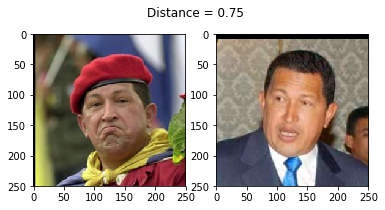

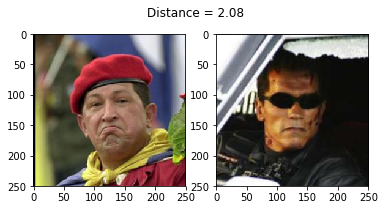

In [7]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(6,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(78, 76)
show_pair(78, 17)

In [8]:
def recognize(embedded):
    min_dist = 100
    _id = None
    for name,emb in real_name.items():
        dist = np.sum(np.square(emb - embedded))


        if dist < min_dist:
            min_dist = dist
            _id = name
    if min_dist > 0.58:
        print(min_dist)
        return None
    else:
        print(min_dist)
        return _id

    

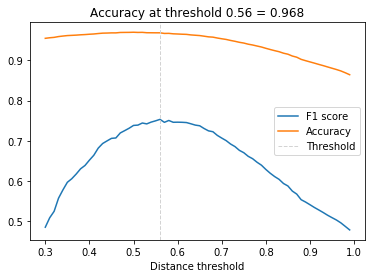

In [9]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

In [10]:
embedded = np.zeros((1, 128))


def recognize_image(image_path):
    img = load_image(image_path)
    img = align_image(img)
    if img is not None:
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded = nn4_small2_pretrained.predict(np.expand_dims(np.array(img), axis=0))[0]
        name = recognize(embedded)
        print(name)
        return name
    return None


cap = cv2.VideoCapture(1)


# def webcam_recognize():
#     while(True): 
#         ret, frame = cap.read()
#         cv2.imwrite('temp.jpg',frame)
#         cv2.waitKey(20)
#         if 'temp.jpg' is not None:
#             name = recognize_image('temp.jpg')
#             cv2.imshow('temp',frame)
#             print(name)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
        
#     cap.release()
#     cv2.destroyAllWindows()


   # webcam_recognize()
# recognize_image('.jpg')

#students list for gspread updations
students = []

from mtcnn.mtcnn import MTCNN
import pickle
def multiple_recognize():
    while(True):
        ret,frame = cap.read()
        cv2.imwrite('temp.jpg',frame)
        detector = MTCNN()
        image = load_image('temp.jpg')
        faces = detector.detect_faces(image)
        print(faces)
        if faces is not None:
            for face in faces:
                (x,y,w,h) = face['box']
                cv2.imwrite('temp.jpg',frame)
                if 'temp.jpg' is not None:
                    name = recognize_image('temp.jpg')
                    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),5)
                    cv2.imshow('Faces',frame)
                    if name!=None and name not in students:    
                        students.append(name)
        stud_names = open('present.pickle','wb')
        pickle.dump(students, stud_names,protocol=2)
        stud_names.close()
                    
                      
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
                
#                 cv2.imshow('parts',image[y:y+h,x:x+w])

multiple_recognize()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[{'box': [537, 198, 117, 150], 'confidence': 0.9738320708274841, 'keypoints': {'left_eye': (559, 245), 'right_eye': (609, 249), 'nose': (571, 283), 'mouth_left': (556, 311), 'mouth_right': (600, 315)}}]
[{'box': [539, 202, 113, 145], 'confidence': 0.9769648313522339, 'keypoints': {'left_eye': (562, 246), 'right_eye': (610, 251), 'nose': (572, 281), 'mouth_left': (557, 308), 'mouth_right': (600, 313)}}]
[{'box': [529, 200, 125, 158], 'confidence': 0.9911994338035583, 'keypoints': {'left_eye': (574, 260), 'right_eye': (632, 253), 'nose': (613, 296), 'mouth_left': (586, 326), 'mouth_right': (633, 321)}}]
[{'box': [523, 184, 132, 167], 'confidence': 0.9875682592391968, 'keypoints': {'left_eye': (540, 241), 'right_eye': (595, 245), 'nose': (548, 285), 'mouth_left': (543, 318), 'mouth_right': (588, 320)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [55

In [11]:
import datetime
import os
import subprocess as s

s.call("python mark_attendance.py", shell=True)
# today = datetime.date.today()
# formatted_date = today.strftime("%m-%d-%Y")
# print(formatted_date)

# from mark_attendance import mark_attendance

# mark_attendance(students)


0